Hydro inflow changes


Hydrop inflow in 

In [14]:
import pandas as pd
from calendar import monthrange
from datetime import datetime, timedelta

# 1. Load the input file
# - It should have 'Month' column with 'Jan', 'Feb', ..., 'Dec'
# - Each plant_name's ID as a column with corrected daily energy in MWh
df = pd.read_excel("C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/From CETT/hydro_profiles_final.xlsx", sheet_name="Average generation MWH day")

# 2. Convert month names to numbers
plant_name = {7,10,19,9,12,21,13,20,8,24,16,17,18,22,23,26,27,28,29,14,15,63,4,1,2,3,11,6,5,30,25
}


# 3. Set month as index for easy lookup
df.set_index('Month', inplace=True)

# 4. Generate hourly timestamps for the entire year (e.g., 2013)
timestamps = []
for month in range(1, 13):
    days = monthrange(2013, month)[1]
    for day in range(1, days + 1):
        for hour in range(24):
            timestamps.append(datetime(2013, month, day, hour))

# 5. For each plant_name column, calculate the hourly inflow
records = []

for plant_name in df.columns:
    hourly_inflow = []
    for month in range(1, 13):
        daily_mwh = df.loc[month, plant_name]
        hourly_mw = daily_mwh / 24
        hours_in_month = monthrange(2013, month)[1] * 24
        hourly_inflow.extend([hourly_mw] * hours_in_month)

    # Sanity check: should match 8760
    assert len(hourly_inflow) == 8760, f"{plant_name} has incorrect hour count."

    # 6. Combine with timestamps
    for time, inflow in zip(timestamps, hourly_inflow):
        records.append({
            "plant_name": plant_name,
            "time": time,
            "inflow": inflow
        })

# 7. Output to CSV
output_df = pd.DataFrame(records)
output_df.to_csv("C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/hourly_inflow_output.csv", index=False)


In [5]:
# Corrected script
import xarray as xr
import pandas as pd

# Read the CSV file
df = pd.read_csv("C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/hourly_inflow_output.csv", sep=",")

# Define the output NetCDF file path
nc = "C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/custom_profile_hydro.nc"

# Convert the DataFrame to an xarray Dataset
dataset = xr.Dataset.from_dataframe(df.reset_index())

# Save the Dataset to a NetCDF file
dataset.to_netcdf(nc)

print(f"NetCDF file has been saved to: {nc}")


NetCDF file has been saved to: C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/custom_profile_hydro.nc


In [12]:
import xarray as xr
import pandas as pd

# Load the external .nc file
external_nc_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/custom_profile_hydro.nc"  # Replace with the actual path
external_ds = xr.open_dataset(external_nc_path)

# Extract variables from the external dataset
plant = external_ds["plant"].values
time = external_ds["time"].values
inflow = external_ds["inflow"].values

# Create a DataFrame from the extracted variables
df = pd.DataFrame({"plant": plant, "time": time, "inflow": inflow})

# Convert the 'time' column to datetime
df["time"] = pd.to_datetime(df["time"])

# Convert the 'plant' column to strings
df["plant"] = df["plant"].astype(str)

# Pivot the DataFrame to reshape it
reshaped_df = df.pivot(index="time", columns="plant", values="inflow")

# Convert the reshaped DataFrame to an xarray Dataset
reshaped_ds = reshaped_df.to_xarray()

# Save the reshaped Dataset to a new .nc file
reshaped_nc_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/custom_profiles_hydro.nc"  # Replace with the desired output path
reshaped_ds.to_netcdf(reshaped_nc_path)

print(f"Reshaped .nc file saved to: {reshaped_nc_path}")

Reshaped .nc file saved to: C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/custom_profiles_hydro.nc


In [32]:
import xarray as xr
ds = xr.open_dataset("C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/profile_hydro.nc")
print(ds)

b=xr.open_dataset("C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/custom_profile_hydro.nc")
print(b)

<xarray.Dataset>
Dimensions:  (plant: 31, time: 8760)
Coordinates:
  * plant    (plant) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 63
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...
<xarray.Dataset>
Dimensions:  (plant: 31, time: 8760)
Coordinates:
  * plant    (plant) int32 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 63
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...


In [30]:
import xarray as xr
import pandas as pd

# Load the external .nc file
external_nc_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/custom_profile_hydro.nc"
external_ds = xr.open_dataset(external_nc_path)

# Extract variables from the external dataset
plant = external_ds["plant"].values
time = external_ds["time"].values
inflow = external_ds["inflow"].values

# Create a DataFrame from the extracted variables
df = pd.DataFrame({"plant": plant, "time": time, "inflow": inflow})

# Convert the 'time' column to datetime
df["time"] = pd.to_datetime(df["time"])

# Convert the 'plant' column to integers (if necessary)
df["plant"] = df["plant"].astype(int)

# Pivot the DataFrame to reshape it
reshaped_df = df.pivot(index="time", columns="plant", values="inflow")

# Ensure the columns (plants) are sorted correctly
reshaped_df = reshaped_df.sort_index(axis=1)

# Convert the reshaped DataFrame to an xarray Dataset with explicit dimensions
reshaped_ds = xr.Dataset(
    {"inflow": (["plant", "time"], reshaped_df.T.values)},  # Transpose to fix dimension order
    coords={
        "plant": reshaped_df.columns,
        "time": reshaped_df.index
    }
)

# Save the reshaped Dataset to a new .nc file
reshaped_nc_path = "C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/custom_profile_hydro.nc"
reshaped_ds.to_netcdf(reshaped_nc_path)

print(f"Reshaped .nc file saved to: {reshaped_nc_path}")

Reshaped .nc file saved to: C:/Users/hie/pe_tan/pypsa-earth/Hydrodata/custom_profile_hydro.nc


AHA atlas

In [ ]:
import pandas as pd
import numpy as np
from calendar import monthrange
from datetime import datetime, timedelta

# --- Load your CSV
df = pd.read_excel("C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/Reservoir_Storage_Capacity_in_MWh_calc.xlsx", sheet_name="Capacity factors")   



# --- Create hourly datetime index for 2013
start_time = datetime(2013, 1, 1, 0)
hourly_times = [start_time + timedelta(hours=i) for i in range(8760)]

# --- Prepare output
records = []

# --- Monthly capacity factor columns
month_cols = [
    "January_capacity_factor_dry", "February_capacity_factor_dry", "March_capacity_factor_dry", "April_capacity_factor_dry", "May_capacity_factor_dry", "June_capacity_factor_dry",
    "July_capacity_factor_dry", "August_capacity_factor_dry", "September_capacity_factor_dry", "October_capacity_factor_dry", "November_capacity_factor_dry", "December_capacity_factor_dry"
]

# --- Create hourly datetime index for 2013
start_time = datetime(2013, 1, 1, 0)
hourly_times = [start_time + timedelta(hours=i) for i in range(8760)]

# --- Prepare output
records = []

# --- Loop through each plant_name
for idx, row in df.iterrows():
    plant_name = row["Name"]
    capacity = row["Capacity (MW)"]
    inflow_series = []

    for i, month_col in enumerate(month_cols, start=1):
        cf = row[month_col]
        hours = monthrange(2013, i)[1] * 24
        inflow = cf * capacity
        inflow_series.extend([inflow] * hours)

    # Add to records
    for time, inflow in zip(hourly_times, inflow_series):
        records.append({
            "plant_name": plant_name,
            "time": time,
            "inflow": inflow
        })

# --- Convert to DataFrame
long_df = pd.DataFrame(records)


# --- Save to CSV
long_df.to_csv("C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/hydro_inflows_2013_dry.csv", index=False)


<xarray.Dataset>
Dimensions:  (plant: 31, time: 8760)
Coordinates:
  * plant    (plant) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 63
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...
Frozen({'plant': <xarray.IndexVariable 'plant' (plant: 31)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 63], dtype=int64), 'time': <xarray.IndexVariable 'time' (time: 8760)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T01:00:00.000000000',
       '2013-01-01T02:00:00.000000000', ..., '2013-12-31T21:00:00.000000000',
       '2013-12-31T22:00:00.000000000', '2013-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]'), 'inflow': <xarray.Variable (plant: 31, time: 8760)>
[271560 values with dtype=float64]})
<xarray.DataArray 'inflow' (plant: 31, time: 8760)>
[271560 values with dtype=float64]
Coordinates:
  * plant    (plant)

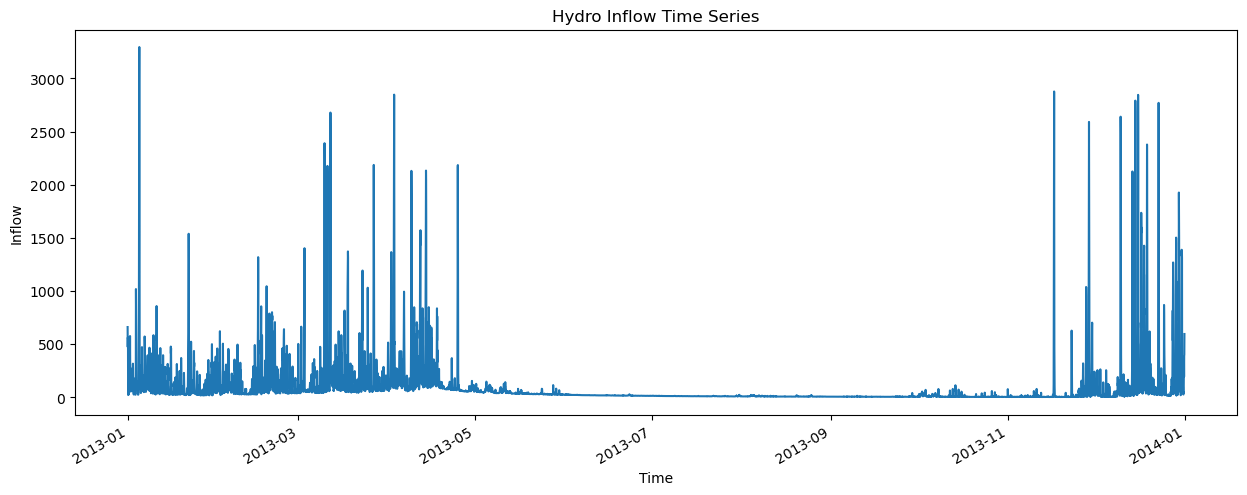

Hydro profile has been saved to Excel.


In [ ]:
import xarray as xr

# Load the NetCDF file
hydro_profile = xr.open_dataset('C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/profile_hydro.nc')

# Display the structure of the dataset
print(hydro_profile)

# Display the variables in the dataset
print(hydro_profile.variables)

# Display the data for a specific variable (e.g., "inflow")
if "inflow" in hydro_profile:
    print(hydro_profile["inflow"])


import matplotlib.pyplot as plt

# Plot the inflow time series for a specific location (if applicable)
if "inflow" in hydro_profile:
    hydro_profile["inflow"].isel(plant_name=0).plot(figsize=(15, 5))  # Replace "bus=0" with the appropriate dimension
    plt.title("Hydro Inflow Time Series")
    plt.ylabel("Inflow")
    plt.xlabel("Time")
    plt.show()


import pandas as pd

# Convert the NetCDF dataset to a pandas DataFrame
hydro_df = hydro_profile.to_dataframe()

# Save the DataFrame to an Excel file
hydro_df.reset_index().to_excel('C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/renewable_profiles/profile_hydro.xlsx', index=False)

print("Hydro profile has been saved to Excel.")

Jan inflow time series- existing hydro

In [ ]:
import pandas as pd

# File path to the Excel file
path = "C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/hydro_profile_inp.xlsx"

# Read the Excel file
hydro_df = pd.read_excel(path, sheet_name="input_generation")

# Display the first few rows of the DataFrame for verification
print("Input Data:")
print(hydro_df.head())

# Identify columns representing hours (1 to 8760)
hour_columns = [col for col in hydro_df.columns if col not in ["year", "plant_name"]]

# Reshape the DataFrame: Melt the hours (columns) into rows
hydro_melted = hydro_df.melt(id_vars=["year", "plant_name"], value_vars=hour_columns, var_name="time", value_name="inflow")

# Convert the 'inflow' column to numeric, coercing invalid values to NaN
hydro_melted["inflow"] = pd.to_numeric(hydro_melted["inflow"], errors="coerce")

# Handle missing values (e.g., fill with 0 or drop them)
hydro_melted["inflow"] = hydro_melted["inflow"].fillna(0)  # Replace NaN with 0

# Group by 'plant_name' and 'time' and calculate the average inflow
average_inflow_df = hydro_melted.groupby(["plant_name", "time"], as_index=False)["inflow"].mean()

# Display the result
print("/nAverage Inflow Time Series:")
print(average_inflow_df.head())

# Save the result to a new Excel file
output_path = "C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/average_hydro_inflow.xlsx"
average_inflow_df.to_excel(output_path, index=False)

print(f"/nAverage inflow time series has been saved to: {output_path}")

Input Data:
   year plant     1     2     3     4     5     6     7     8  ...  8752  \
0  2008  HALE  4.60  4.20  4.11  4.10  3.07  3.62  3.90  4.31  ...  4.03   
1  2009  HALE  5.18  5.18  5.18  5.18  5.18  5.18  8.48  8.62  ...  9.24   
2  2010  HALE  9.23  9.05  9.80  8.60  8.52  7.20  7.36  9.32  ...  4.20   
3  2011  HALE  4.03  4.03  4.40  4.41  4.99  4.30  7.02  7.90  ...  0.00   
4  2012  HALE  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  5.27   

   8753  8754  8755  8756  8757  8758   8759  8760      total  
0  4.41  5.75  8.69  8.35  7.58  8.39   6.84  7.54  60059.609  
1  8.94  8.06  7.70  9.37  8.70  7.89  10.37  9.86  42744.318  
2  4.68  4.81  4.75  7.11  6.99  7.24   4.71  4.58  49001.744  
3  0.00  0.00  0.00  0.00  0.00  0.00   0.00  0.00   2533.480  
4  3.75  4.33  4.71  6.16  6.53  6.81   3.49  4.14  32693.598  

[5 rows x 8763 columns]

Average Inflow Time Series:
  plant time    inflow
0  HALE    1  4.393846
1  HALE    2  4.330000
2  HALE    3  4.161538
3

In [ ]:
import pandas as pd

# File path to the input data (in MW/day)
input_file = "C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/hydro_profiles_final.xlsx"  # Replace with your file path
output_file = "C:/Users/hie/OneDrive - Multiconsult/Dokumenter/NMBU/Master/Model/Hydro inflow/hydro_profiles_average.xlsx"  # Replace with your desired output path

# Read the input Excel file
df = pd.read_excel(input_file, sheet_name="hydro_inflow_prosp_res")

print(df.head())  # Display the first few rows of the DataFrame for verification

# Ensure the input data contains the required columns
#power_plant_names=["Julius Nyerere","Ruhudji","Rumakali","Kikonge","	Songwe Manolo",	"Mpanga","Songwe Sofre","Ikondo Mnyera","Rusumo","Upper Kihansi","Malagaresi","Masigira","Songwe Bipungu","Iringa Nginayo","Iringa Ibosa","Yovi","Matembwe","Darakuta","Andoya","Taveta","Kakono","Tosamaganga"]
#required_columns = ["Month", "Date", ""]
#if not all(col in df.columns for col in required_columns):
#    raise ValueError(f"The input file must contain the following columns: {required_columns}")

# Ensure the input data contains the required columns
required_columns = ["Month", "Date"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"The input file must contain the following columns: {required_columns}")

# Convert the 'date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Extract the power plant_name columns (all columns except 'month' and 'date')
power_plant_name_columns = [col for col in df.columns if col not in ["Month", "Date"]]

# Convert MW/day to MW/hour for each power plant_name
hourly_data = []
for _, row in df.iterrows():
    for hour in range(24):
        for plant_name in power_plant_name_columns:
            hourly_data.append({
                "plant_name": plant_name,
                "datetime": row["Date"] + pd.Timedelta(hours=hour),
                "inflow_mw_per_hour": row[plant_name] / 24  # Convert daily inflow to hourly inflow
            })

# Create a new DataFrame for hourly data
hourly_df = pd.DataFrame(hourly_data)

# Sort the DataFrame by the 'plant_name' column
hourly_df = hourly_df.sort_values(by="plant_name")

# Save the hourly data to an Excel file
hourly_df.to_excel(output_file, index=False)

print(f"Hourly inflow data has been saved to: {output_file}")

        Date  Month  Julius Nyerere        Ruhudji       Rumakali  \
0 2013-01-01      1         1235160  266666.666667  176266.666667   
1 2013-01-02      1         1235160  266666.666667  176266.666667   
2 2013-01-03      1         1235160  266666.666667  176266.666667   
3 2013-01-04      1         1235160  266666.666667  176266.666667   
4 2013-01-05      1         1235160  266666.666667  176266.666667   

        Kikonge  Songwe Manolo        Mpanga  Songwe Sofre  Ikondo Mnyera  \
0  107522.53508   62933.333333  88489.397678         51000  244266.666667   
1  107522.53508   62933.333333  88489.397678         51000  244266.666667   
2  107522.53508   62933.333333  88489.397678         51000  244266.666667   
3  107522.53508   62933.333333  88489.397678         51000  244266.666667   
4  107522.53508   62933.333333  88489.397678         51000  244266.666667   

   ...  Songwe Bipungu  Iringa Nginayo  Iringa Ibosa         Yovi   Matembwe  \
0  ...           10200           35040  24

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_24h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores



Total consumption in TWh: 0.44
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='snapshot', length=365, freq=None)
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='snapshot', length=365, freq=None)
None


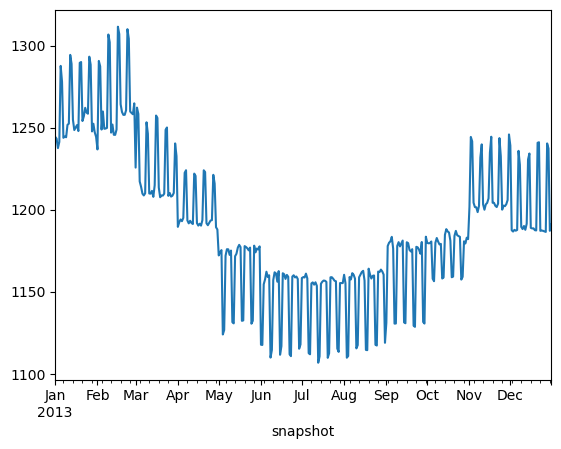

In [62]:
n.iplot(mapbox='osm')

{'data': [Scattermapbox({
      'lat': [-6.7933, -6.7933],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [39.2077, 39.2077],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-2.543, -2.543],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [32.967, 32.967],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-6.7988, -6.7988],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [37.6638, 37.6638],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-8.9146, -8.9146],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [33.4967, 33.4967],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.4156, -3.4156],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [36.711, 36.711],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.6219, -3.6219],
      'line'

Totalt årlig forbruk i TWh: 0.44
